# Directly importing a small chunk of dataset from the website and making a time series problem out of it with 4 features (including the lagged/previous velocities) and 1 lable (velocity).
# Introduced a new coloum of previous velocity by shifting the target variable to create a lag (storing the velocity of previous time step).
# Introduced splitting of the dataset into training, validation, and test sets (70-15-15 split)
# Tried to use an autoregressive LSTM model and make some future velocity predictions.
# Plotted the prediction results for the first 5 time steps

In [129]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [130]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2.14.0


In [132]:
# Defining columns to use
columns_to_use = ["global_x", "global_y", "v_vel", "v_acc", "global_time"] #using just 4 of them

# Defining chunk size for reading data
chunk_size = 100

# Initializing an empty list to store data chunks
data_chunks = []

for chunk in pd.read_csv("https://data.transportation.gov/resource/8ect-6jqj.csv", 
                         chunksize=chunk_size, usecols=columns_to_use):
    data_chunks.append(chunk)

# Concatenate data chunks into a single DataFrame
velocity_dataset = pd.concat(data_chunks, ignore_index=True)

# trajectory_dataset = pd.read_csv(
#     "https://data.transportation.gov/resource/8ect-6jqj.csv")

#   names=["Vehicle_ID", "Frame_Id", "Total_Frames", "Global_Time", "Local_X",
#            "Local_Y", "Global_X", "Global_Y", "v_length", "v_Width", "v_Vel", 
#            "v_Acc", "Lane_ID", "O_Zone", "D_Zone", "Int_ID", "Section_ID", "Direction",
#            "Movement", "Preceding", "Following", "Space_Headway", "Time_Headway", "Location"]

In [133]:
velocity_dataset.shape

(1000, 5)

In [134]:
velocity_dataset.head()

,global_time,global_x,global_y,v_vel,v_acc
0,1163368300,2230502.921,1375532.938,33.96,0.00
1,1163368200,2230503.114,1375537.934,33.96,0.00
2,1163368100,2230502.731,1375540.951,33.96,0.00
3,1163368000,2230502.906,1375544.692,33.96,10.82
4,1163051100,2230518.568,1375546.762,0.25,-4.89


In [135]:
velocity_dataset_sorted = velocity_dataset.sort_values(by='global_time')

In [136]:
velocity_dataset_sorted

,global_time,global_x,global_y,v_vel,v_acc
434,1163034800,2230519.322,1375566.277,17.29,0.0
503,1163034900,2230519.899,1375568.256,17.29,0.0
553,1163035000,2230519.957,1375569.755,17.29,0.0
710,1163035100,2230519.535,1375571.773,17.29,0.0
949,1163035200,2230520.612,1375573.733,17.29,0.0
...,...,...,...,...,...
528,1163849900,2230532.048,1375568.927,25.71,0.0
643,1163850000,2230532.204,1375571.494,25.71,0.0
563,1163850000,2230520.798,1375569.938,37.39,0.0
966,1163850100,2230532.360,1375574.060,25.71,0.0


In [137]:
# Shift the target variable to create a lag (storing the velocity of previous time step)
velocity_dataset_sorted['v_vel_previous'] = velocity_dataset_sorted['v_vel'].shift(1)

# Drop the first row since it will have NaN in the lagged column
velocity_dataset_sorted = velocity_dataset_sorted.dropna()

In [138]:
velocity_dataset_sorted

,global_time,global_x,global_y,v_vel,v_acc,v_vel_previous
503,1163034900,2230519.899,1375568.256,17.29,0.0,17.29
553,1163035000,2230519.957,1375569.755,17.29,0.0,17.29
710,1163035100,2230519.535,1375571.773,17.29,0.0,17.29
949,1163035200,2230520.612,1375573.733,17.29,0.0,17.29
99,1163036300,2230519.819,1375553.248,25.79,0.0,17.29
...,...,...,...,...,...,...
528,1163849900,2230532.048,1375568.927,25.71,0.0,37.39
643,1163850000,2230532.204,1375571.494,25.71,0.0,25.71
563,1163850000,2230520.798,1375569.938,37.39,0.0,25.71
966,1163850100,2230532.360,1375574.060,25.71,0.0,37.39


In [139]:
input_features = ["global_x", "global_y", "v_acc", "v_vel_previous"]
output_labels = ["v_vel"]

# input_dataset = velocity_dataset_sorted[input_features]
# output_dataset = velocity_dataset_sorted[output_labels]

In [140]:
# Split the dataset into training, validation, and test sets (70-15-15 split)
# train_features, temp_features, train_labels, temp_labels = train_test_split(input_dataset, output_dataset, test_size=0.3, random_state=42)
# validation_features, test_features, validation_labels, test_labels = train_test_split(temp_features, temp_labels, test_size=0.5, random_state=42)

# Split the dataset into training (70%) and temp (30% for validation and test)
train_data, temp_data = train_test_split(velocity_dataset_sorted, test_size=0.3, random_state=42)

# Split the temp dataset into validation (15% of total) and test (15% of total)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Separate features and labels for training set
train_features = train_data[input_features]
train_labels = train_data[output_labels]

# Separate features and labels for validation set
validation_features = validation_data[input_features]
validation_labels = validation_data[output_labels]

# Separate features and labels for test set
test_features = test_data[input_features]
test_labels = test_data[output_labels]

# Print the shapes of the splits to verify
print("Training features shape:", train_features.shape)
print("Training labels shape:", train_labels.shape)
print("Validation features shape:", validation_features.shape)
print("Validation labels shape:", validation_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

Training features shape: (699, 4)
Training labels shape: (699, 1)
Validation features shape: (150, 4)
Validation labels shape: (150, 1)
Test features shape: (150, 4)
Test labels shape: (150, 1)


In [145]:
test_features

,global_x,global_y,v_acc,v_vel_previous
289,2230521.573,1375560.340,0.00,3.09
505,2230519.400,1375568.275,0.00,10.10
25,2230518.666,1375548.285,-0.37,3.74
450,2230531.352,1375566.812,0.00,33.03
917,2230521.786,1375573.213,0.00,1.07
...,...,...,...,...
514,2230521.418,1375568.698,0.00,5.70
384,2230530.265,1375564.538,-11.63,20.76
460,2230521.859,1375567.179,0.00,24.45
259,2230519.346,1375558.740,0.00,3.74


In [147]:
test_labels

,v_vel
289,3.09
505,31.42
25,3.78
450,33.03
917,1.07
...,...
514,5.70
384,16.50
460,32.97
259,3.74


In [148]:
# Normalize the features
feature_normalizer = tf.keras.layers.Normalization(axis=-1)
feature_normalizer.adapt(np.array(train_features))

train_features_normalized = feature_normalizer(np.array(train_features))
validation_features_normalized = feature_normalizer(np.array(validation_features))
test_features_normalized = feature_normalizer(np.array(test_features))

# Prepare the input and output for LSTM
X_train, y_train = [], []
X_validation, y_validation = [], []
X_test, y_test = [], []

In [149]:
# Create training data
for i in range(1, len(train_features_normalized)):
    X_train.append(train_features_normalized[i-1])
    y_train.append(train_labels.iloc[i])

# Create validation data
for i in range(1, len(validation_features_normalized)):
    X_validation.append(validation_features_normalized[i-1])
    y_validation.append(validation_labels.iloc[i])

# Create testing data
for i in range(1, len(test_features_normalized)):
    X_test.append(test_features_normalized[i-1])
    y_test.append(test_labels.iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_test, y_test = np.array(X_test), np.array(y_test)

In [150]:
# Reshape the features for LSTM [num_samples, time steps, num_features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [157]:
# Define the LSTM model (here the input shape is (1,4))
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), 
                         verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}") # Aggregated value

Epoch 1/100
22/22 [==============================] - 6s 40ms/step - loss: 253.0721 - val_loss: 290.2531
Epoch 2/100
22/22 [==============================] - 0s 22ms/step - loss: 251.5253 - val_loss: 288.0529
Epoch 3/100
22/22 [==============================] - 0s 18ms/step - loss: 248.9299 - val_loss: 283.5665
Epoch 4/100
22/22 [==============================] - 0s 11ms/step - loss: 243.1574 - val_loss: 273.1065
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 229.7840 - val_loss: 249.9840
Epoch 6/100
22/22 [==============================] - 0s 11ms/step - loss: 204.6881 - val_loss: 212.8999
Epoch 7/100
22/22 [==============================] - 0s 10ms/step - loss: 174.3084 - val_loss: 184.5003
Epoch 8/100
22/22 [==============================] - 0s 9ms/step - loss: 159.2370 - val_loss: 174.1297
Epoch 9/100
22/22 [==============================] - 0s 18ms/step - loss: 155.4785 - val_loss: 168.7729
Epoch 10/100
22/22 [==============================] - 0s 14ms/ste

In [158]:
# Predict the first 5 time steps
n_steps = 5
predicted_velocities = []
current_input = X_test[0].reshape(1, 1, X_test.shape[2])  # Start with the first test sample

for i in range(n_steps):
    current_pred = lstm_model.predict(current_input, verbose=0)
    predicted_velocities.append(current_pred[0][0])  # Append the current prediction
    
    if i < len(X_test) - 1:
        # Update current input with the values of the next row, but keep v_vel_previous as the predicted value
        current_input = X_test[i + 1].copy().reshape(1, 1, X_test.shape[2])
        current_input[0, 0, -1] = current_pred[0][0]  # Update v_vel_previous with the predicted value

print("Predicted Velocities:", predicted_velocities)

Predicted Velocities: [8.34766, 29.196146, 102.73505, 386.2775, 1436.0428]


In [159]:
# Calculate errors
true_values = y_test[:n_steps].reshape(-1)
predicted_velocities = np.array(predicted_velocities).reshape(-1)
errors = predicted_velocities - true_values

# Print errors
for i in range(n_steps):
    print(f"Time Step {i+1} - Predicted: {predicted_velocities[i]:.3f}, True: {true_values[i]:.3f}, Error: {errors[i]:.3f}")

Time Step 1 - Predicted: 8.348, True: 31.420, Error: -23.072
Time Step 2 - Predicted: 29.196, True: 3.780, Error: 25.416
Time Step 3 - Predicted: 102.735, True: 33.030, Error: 69.705
Time Step 4 - Predicted: 386.277, True: 1.070, Error: 385.207
Time Step 5 - Predicted: 1436.043, True: 0.240, Error: 1435.803


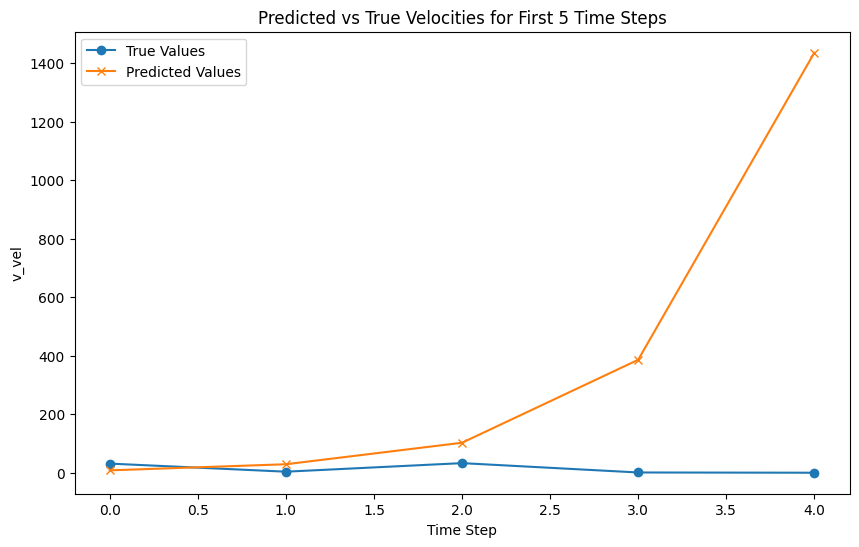

In [160]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(n_steps), true_values, label='True Values', marker='o')
plt.plot(range(n_steps), predicted_velocities, label='Predicted Values', marker='x')
plt.xlabel('Time Step')
plt.ylabel('v_vel')
plt.title('Predicted vs True Velocities for First 5 Time Steps')
plt.legend()
plt.show()

In [268]:
# Find the index of the maximum velocity
max_index = velocity_dataset['v_vel'].idxmax()

# Find the maximum velocity itself
max_velocity = velocity_dataset.loc[max_index, 'v_vel']

print(f"Maximum velocity: {max_velocity}")
print(f"Index of maximum velocity: {max_index}")

Maximum velocity: 51.3
Index of maximum velocity: 75
